## Codes

In [5]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from time import gmtime, strftime
from scipy.signal import butter, lfilter

In [6]:
def dataseparation(flocation):
    '''
    this function change the log.file into dataframe form
    
    input: fname: log file location
    
    output: DataFrame
    '''
    f_1 = open(flocation, 'r') # read files
    lines = f_1.readlines() # read line by line
    f_1.close() # close the file
    new_lines = []
    for l in lines:
        new_lines.append(l.split('\t')) # remove "\t" by line
    
    mHealth = pd.DataFrame(new_lines)
    return mHealth
    

In [7]:
def getsubject(dataFrame):
    '''
    input: dataFrame of dataseparation
    output: ECG1, ECG2
            acceleration ax, ay, az
            acceleration a = sqrt( ax^2 + ay^2 + az^2      
    '''
    ECG1 = pd.to_numeric(dataFrame[3])
    ECG2 = pd.to_numeric(dataFrame[4])
    ax = pd.to_numeric(dataFrame[0])
    ay = pd.to_numeric(dataFrame[1])
    az = pd.to_numeric(dataFrame[2])
    a = np.sqrt(ax**2 + ay**2 + az**2)
    return ECG1, ECG2, ax, ay, az, a

In [8]:
def bandpass_filter(data, signal_freq = 50, lowcut = 0.0001, highcut = 3.0, filter_order = 1):
    '''
    this function is to apply butterworth filter
    input: raw data
           float lowcut
           float highcut
           int signal frequency in samples per second
           filter order
    output: filtered data
    '''
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype = "band")
    y = lfilter(b, a, data)
    return y


In [9]:
def findpeaks(data, spacing=10, limit = 0.01):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind

In [10]:
def detect_peaks(data):
    """
    extracting peaks from loaded ECG measurements data through measurements processing
    input: raw data
    output: peak indices
    """
        # Extract measurements from loaded ECG data.
    ecg_measurements = data

        # Measurements filtering - 0-15 Hz band pass filter.
    filtered_ecg_measurements = bandpass_filter(ecg_measurements)
        #self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
    differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
    squared_ecg_measurements = differentiated_ecg_measurements ** 2

        # Moving-window integration.
    integration_window = 3
    integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

        # Fiducial mark - peak detection on integrated measurements.
    detected_peaks_indices = findpeaks(data=integrated_ecg_measurements)

    detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]
    
    return detected_peaks_indices, detected_peaks_values

In [11]:
def ecg2bpm(detected_peaks_indices):
    '''
    this function converts ecg to bpm
    input: detected peaks indices from qrs_detected_indices
    output: peaks_indice and BPM
    '''
    m = 0
    BPM = np.array([])
    time = np.array([])
    for i in detected_peaks_indices[1:]:
        RR_interval = (i - m) # peak-peak intervals
        m_distance = RR_interval / 50.*1000 # calculate the ms distance
        m = i
        bpm = 60000. / m_distance
        time = np.append(time, i)
        BPM = np.append(BPM, bpm)
    return time, BPM

In [12]:
def detect_qrs(data, detected_peaks_indices, detected_peaks_values):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        input: raw data, detected_peaks_indices and corresponding valus
        output: qrs_peaks_indices, noise_peaks_indices
        
        """
        refractory_period = 24  # Change proportionally when adjusting frequency (in samples).
        qrs_peak_filtering_factor = 0.125
        noise_peak_filtering_factor = 0.125
        qrs_noise_diff_weight = 0.25
        
        qrs_peak_value = 0.0
        noise_peak_value = 0.0
        threshold_value = 0.0
        
        # Detection results.
        qrs_peaks_indices = np.array([], dtype=int)
        noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        ecg_data_detected = None

        for detected_peak_index, detected_peaks_value in zip(detected_peaks_indices, detected_peaks_values):

            try:
                last_qrs_index = qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > refractory_period or not qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > threshold_value:
                    qrs_peaks_indices = np.append(qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    qrs_peak_value = qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - qrs_peak_filtering_factor) * qrs_peak_value
                else:
                    noise_peaks_indices = np.append(noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    noise_peak_value = noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - noise_peak_filtering_factor) * noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                threshold_value = noise_peak_value + \
                                       qrs_noise_diff_weight * (qrs_peak_value - noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(data), 1])
        measurement_qrs_detection_flag[qrs_peaks_indices] = 1
        ecg_data_detected_ = np.append(data, measurement_qrs_detection_flag)
        ecg_data_detected = np.append(ecg_data_detected_, 1)
        
        #return measurement_qrs_detection_flag
        #return ecg_data_detected
        return qrs_peaks_indices, noise_peaks_indices

# testing

In [13]:
filelocation = "/Users/huangzhisheng/Desktop/ECE251B/project/MHEALTHDATASET/mHealth_subject5.log"
mHealth = dataseparation(filelocation)
ECG1, ECG2, ax, ay, az, a = getsubject(mHealth)

In [14]:
ecg_measurements = ECG1 # first minute 50 points per second
detected_peaks_indices, detected_peaks_values = detect_peaks(ecg_measurements)

In [15]:
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ECG1.values, detected_peaks_indices, detected_peaks_values)
print noise_peaks_indices.shape
time, BPM = ecg2bpm(qrs_peaks_indices)

(2625,)


('mean value: ', 62.294932669957987)
('largest value: ', 120.0)


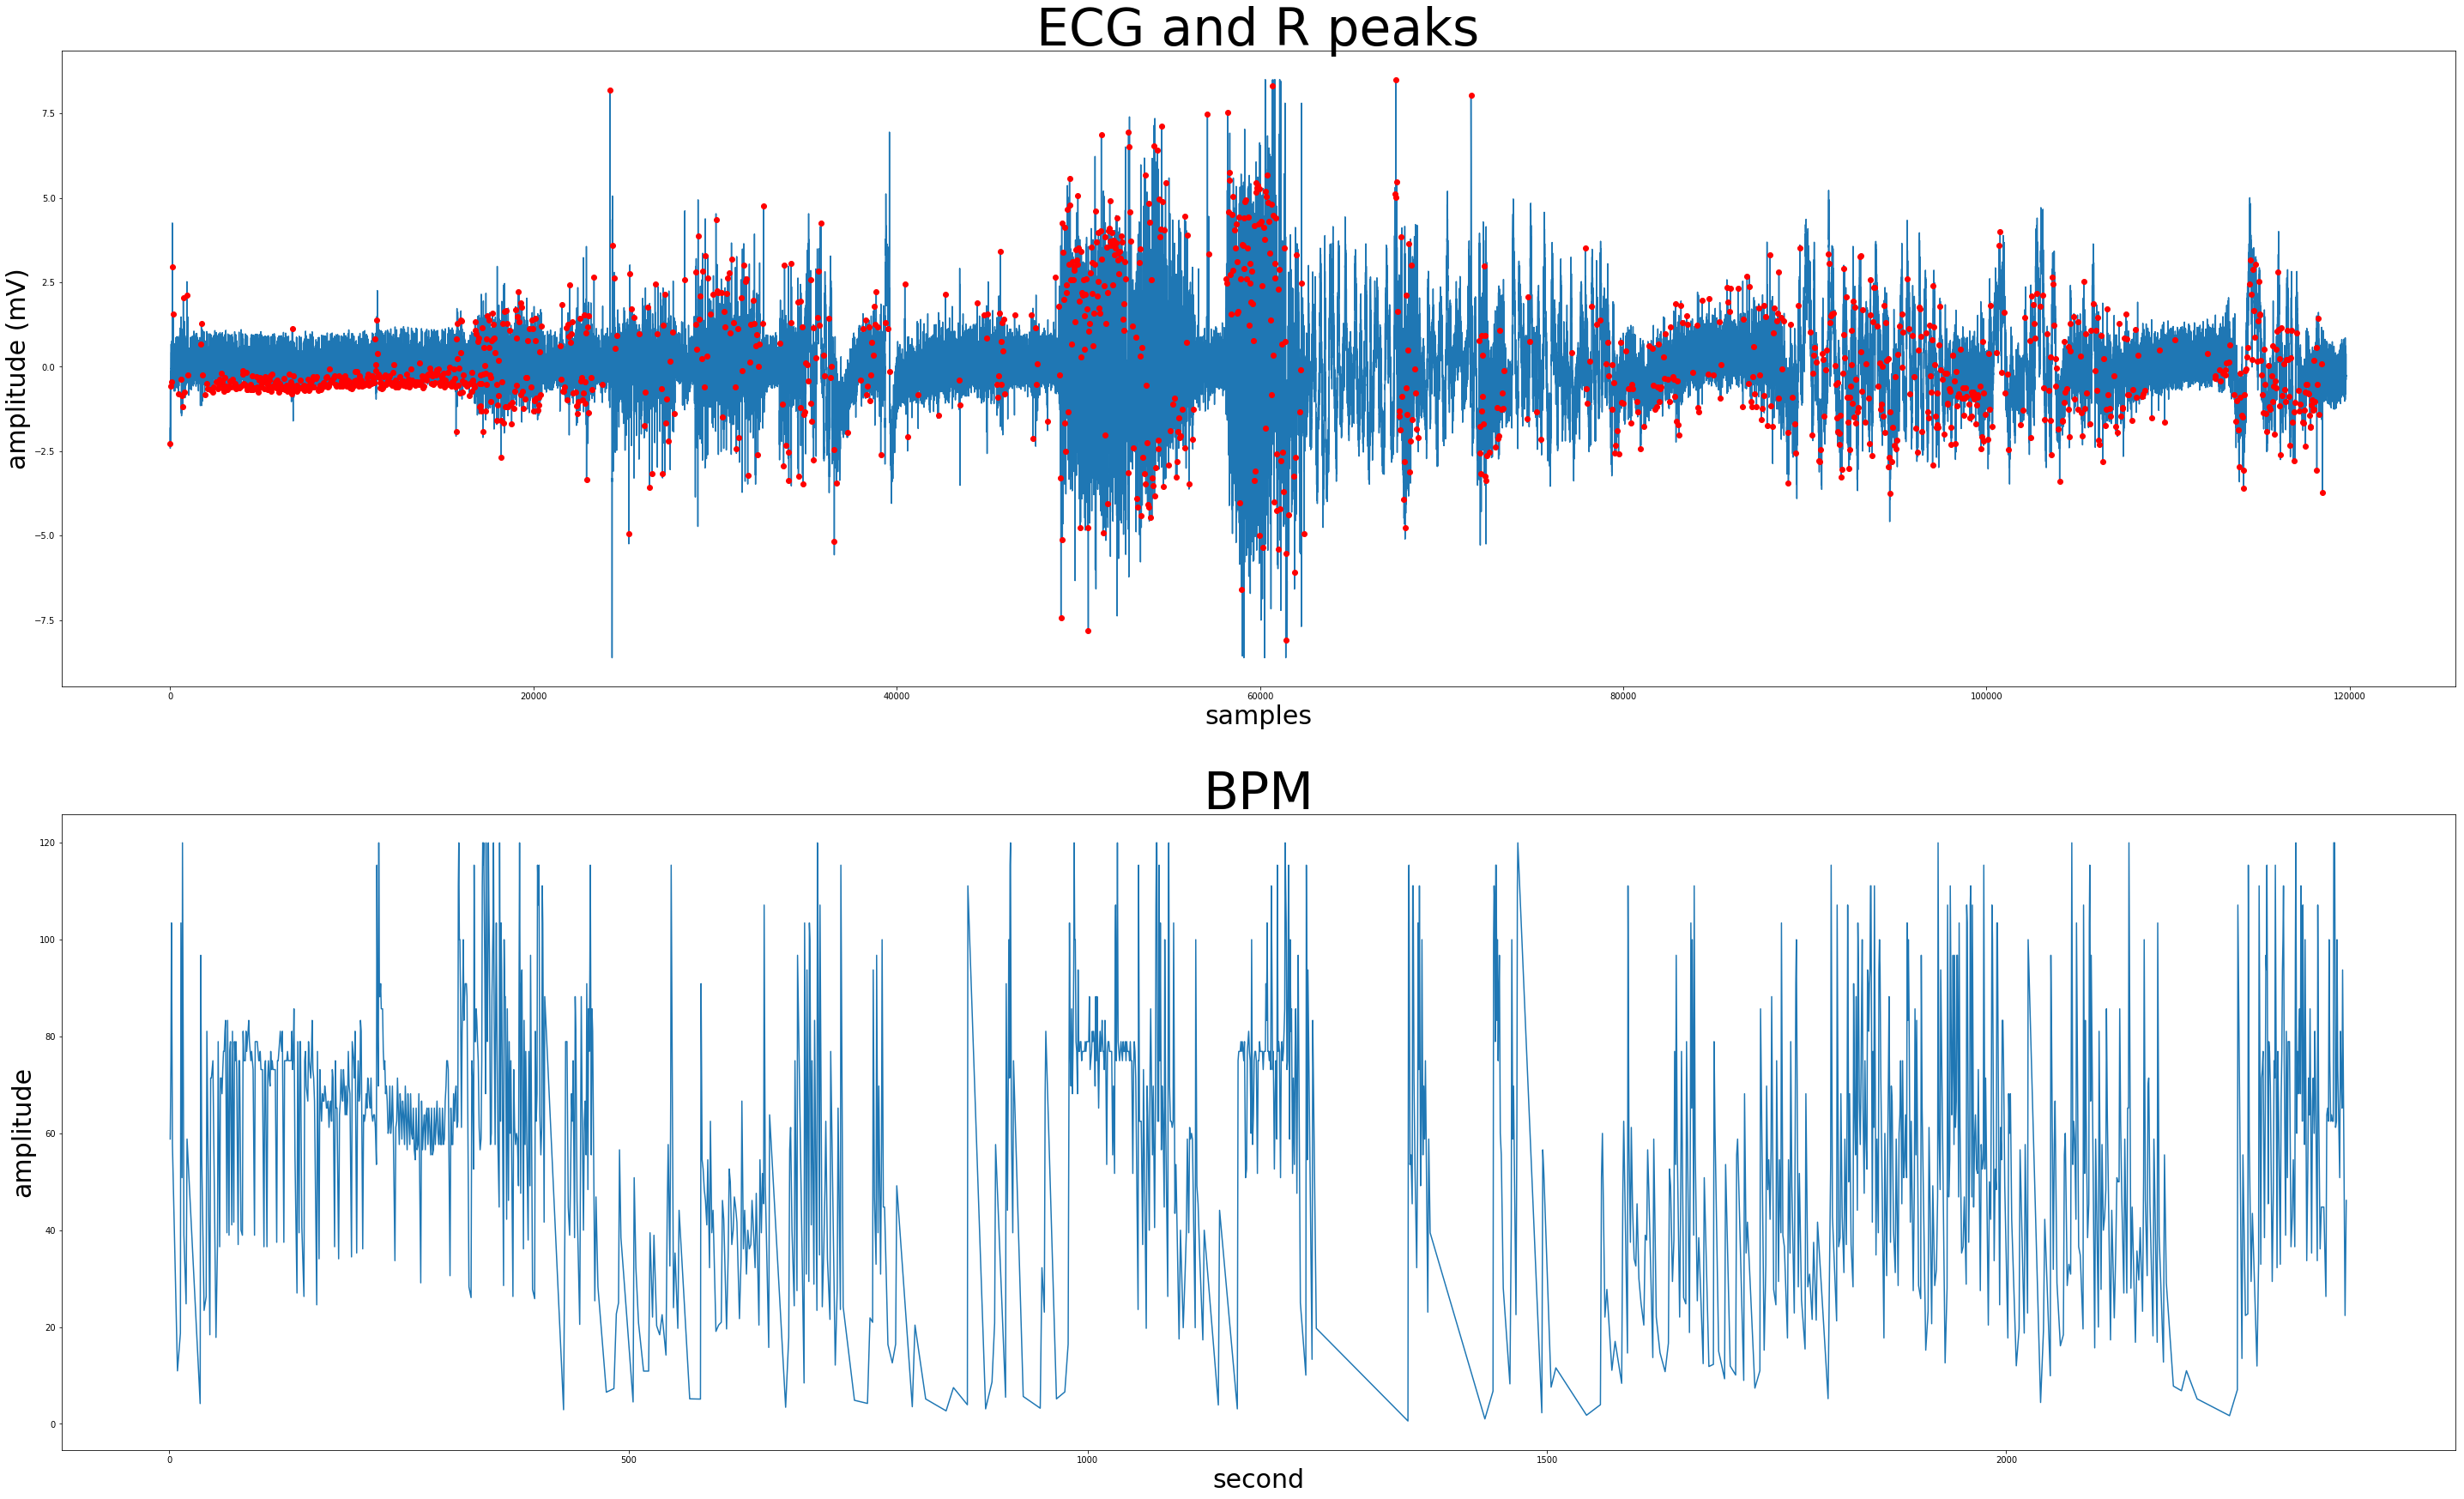

In [16]:
fig = plt.figure(figsize=(50, 30))


subplot1 = fig.add_subplot(2, 1, 1)
subplot2 = fig.add_subplot(2, 1, 2)
subplot1.plot(ecg_measurements.values)
subplot1.plot(qrs_peaks_indices, ecg_measurements.values[qrs_peaks_indices], 'ro' )
subplot1.set_title('ECG and R peaks', fontsize = 60)
subplot1.set_xlabel('samples', fontsize = 30)
subplot1.set_ylabel('amplitude (mV)', fontsize = 30)

subplot2.plot(time*0.02, BPM)
subplot2.set_title('BPM', fontsize = 60)
subplot2.set_xlabel('second', fontsize = 30)
subplot2.set_ylabel('amplitude', fontsize = 30)
print ("mean value: ", BPM.mean())
print ("largest value: ", BPM.max())

In [17]:
n = 0
len(a)
act_level = np.array([])
delt_sum = 0
while n < len(a)-50:
    delt_sum = 0
    for i in range(25):
        delta = a[n + (i+1) * 2] - a[n + 2*i]
        deltt = 5 * 0.02 
        delt_sum = np.sqrt(delta**2 + deltt**2) + delt_sum
   
    
    act_level = np.append(act_level, delt_sum)
    n = n + 50
    
print len(act_level)
print len(a)

2396
119808


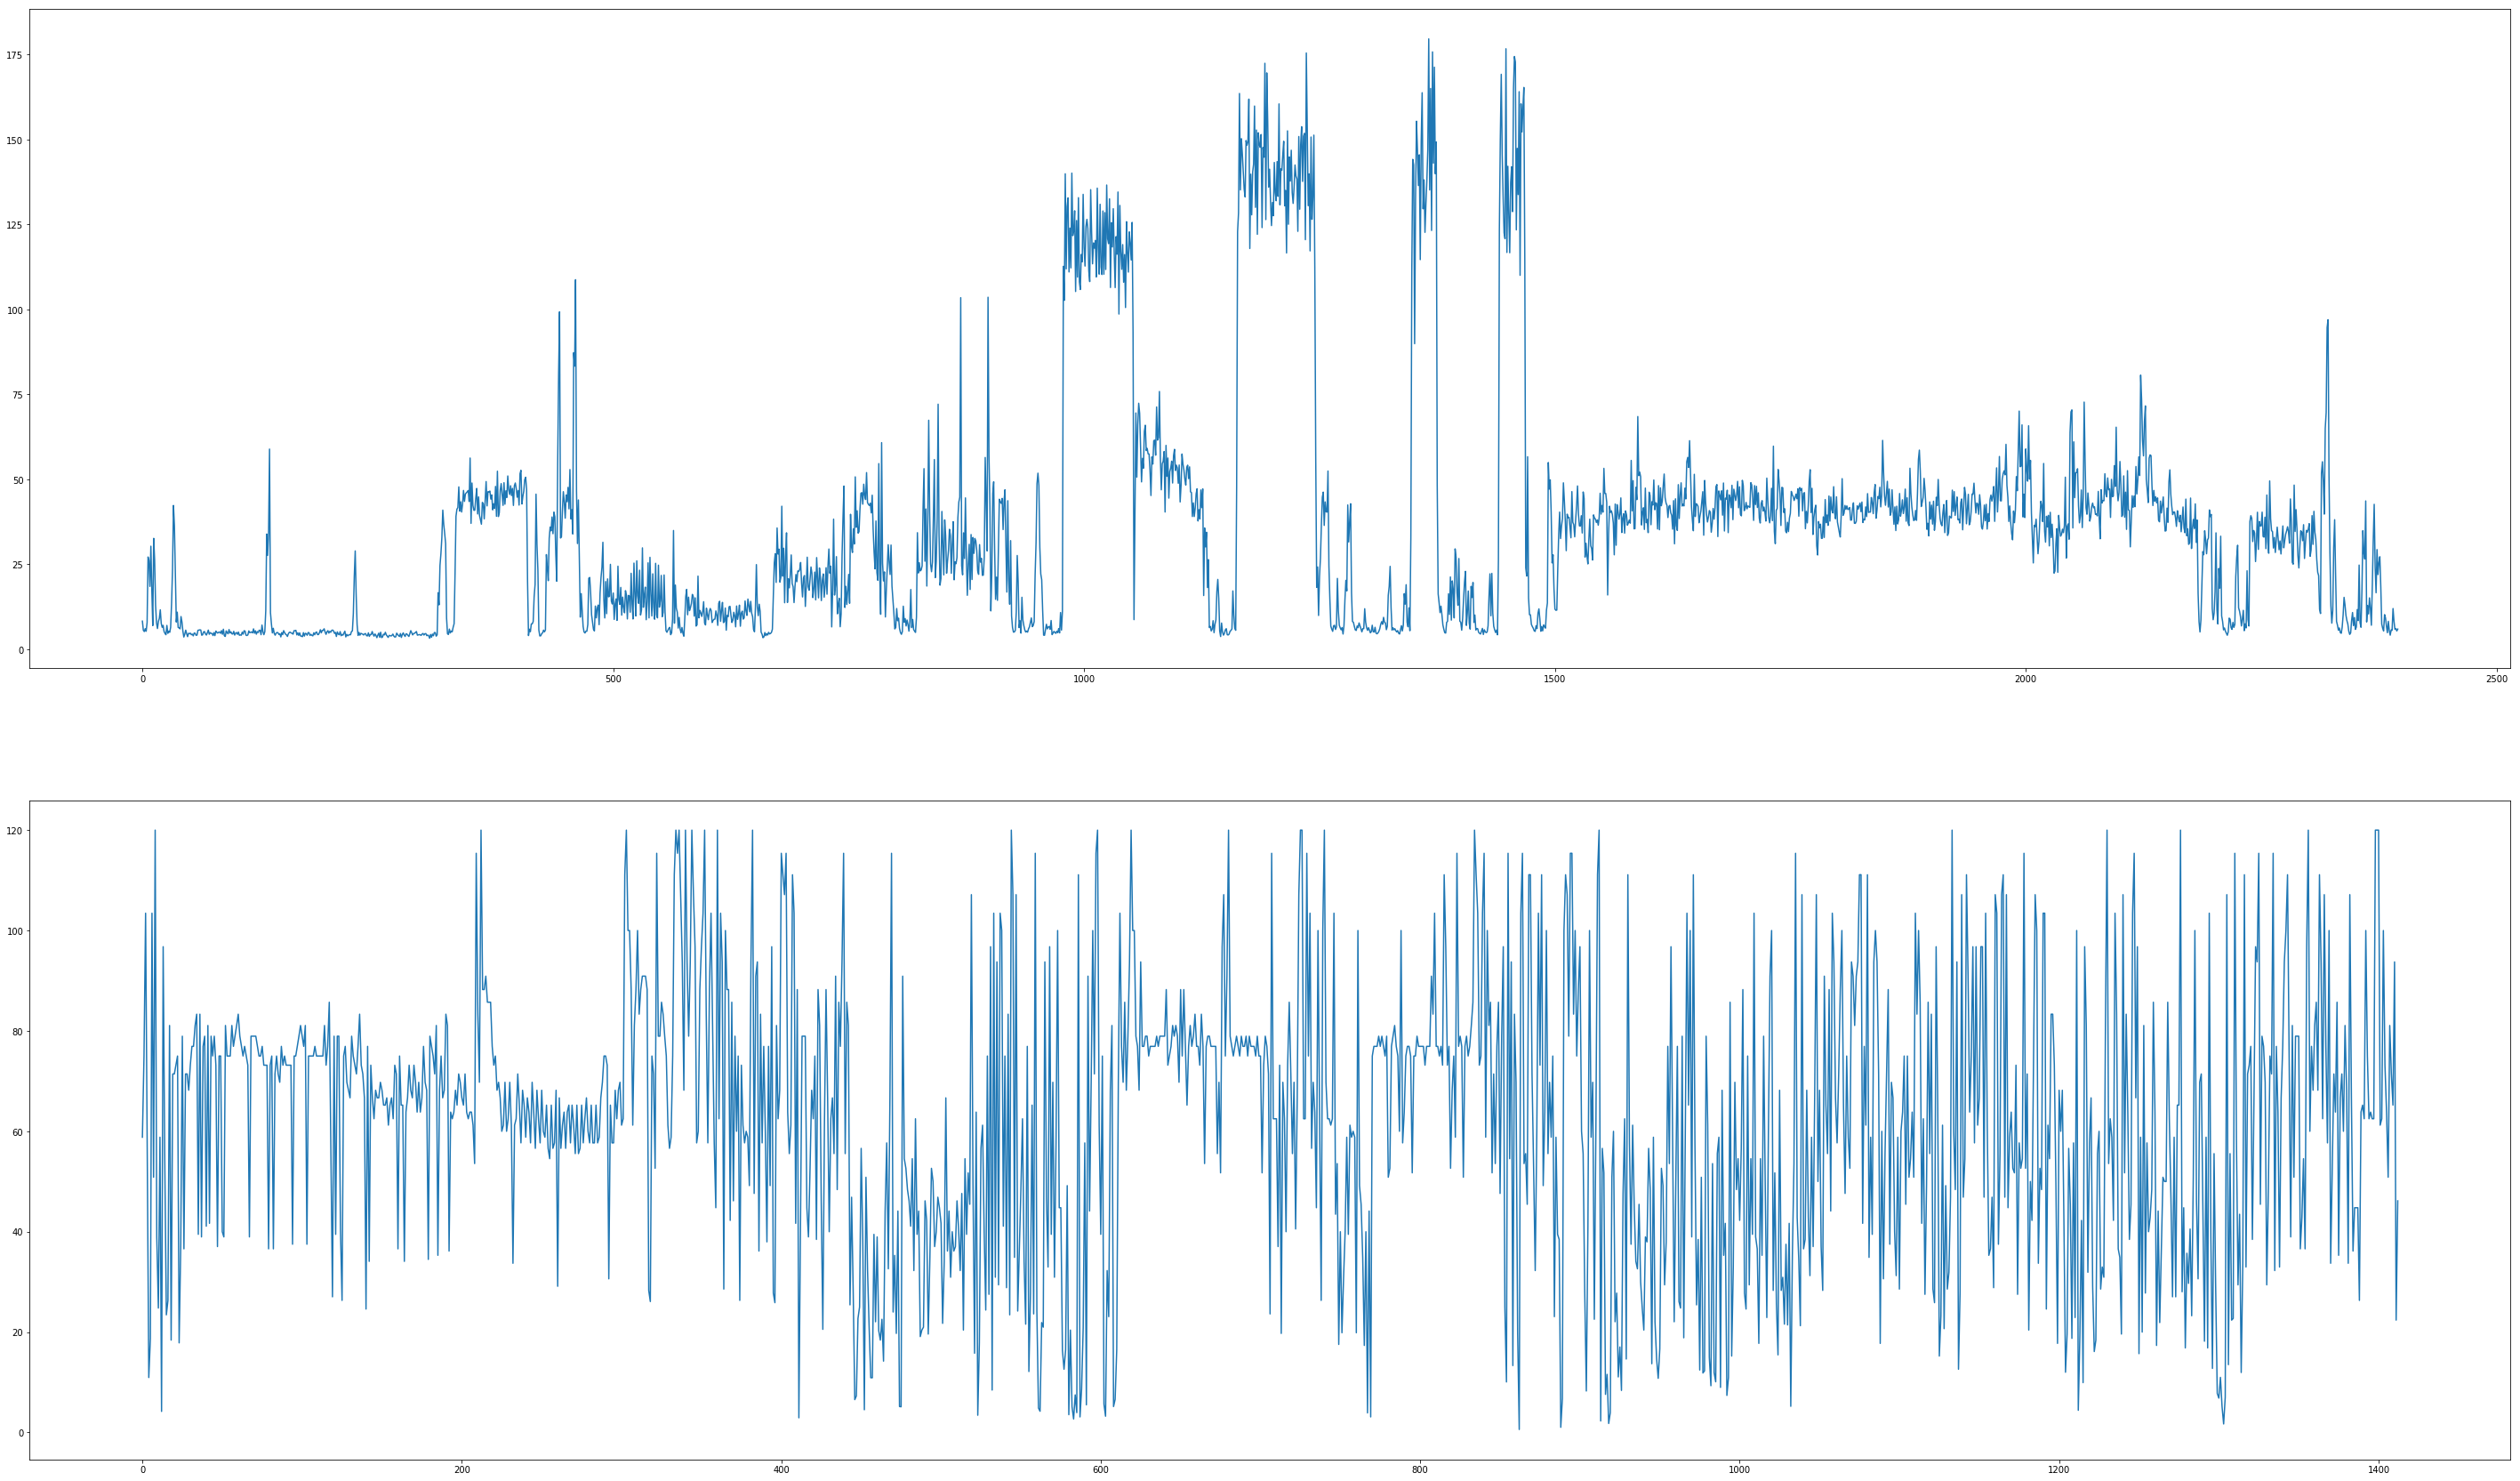

In [18]:
fig = plt.figure(figsize=(50, 30))

subplot1 = fig.add_subplot(2, 1, 1)
subplot2 = fig.add_subplot(2, 1, 2)
subplot1.plot(act_level)
subplot2.plot(BPM[0:15000])